# Interpolating Precipitation Using NOAA Sensors

Here, we will follow a similar methodology to the temperature interpolation to interpolate a model for precipitation in Chicago. See the other notebook for a more detailed description of each step. 

## Load the Required Packages

In [2]:
library(sp)
library(rgdal)
library(rgeos)
library(leaflet)
library(raster)
library(gstat)
library(tmap)
library(tidyverse)

Warning message:
“package ‘rgdal’ was built under R version 3.4.4”rgdal: version: 1.3-4, (SVN revision 766)
 Geospatial Data Abstraction Library extensions to R successfully loaded
 Loaded GDAL runtime: GDAL 2.1.3, released 2017/20/01
 Path to GDAL shared files: /Users/isaackamber/Library/R/3.4/library/rgdal/gdal
 GDAL binary built with GEOS: FALSE 
 Loaded PROJ.4 runtime: Rel. 4.9.3, 15 August 2016, [PJ_VERSION: 493]
 Path to PROJ.4 shared files: /Users/isaackamber/Library/R/3.4/library/rgdal/proj
 Linking to sp version: 1.3-1 
rgeos version: 0.3-26, (SVN revision 560)
 GEOS runtime version: 3.6.1-CAPI-1.10.1 r0 
 Linking to sp version: 1.2-5 
 Polygon checking: TRUE 

Warning message:
“package ‘leaflet’ was built under R version 3.4.4”Warning message:
“package ‘gstat’ was built under R version 3.4.4”Warning message:
“package ‘tmap’ was built under R version 3.4.4”── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 2.2.1     ✔ purrr   0.2.4
✔ tib

## Read in the NOAA Data
We will read in the same file as with the temperature interpolation

In [3]:
noaa.monthly <- read.csv("NOAA_master_monthly_final.csv")

## Isolate the Desired Information
We hope to examine the average precipitation in the city during May of 2012. For now, we are going to take the precipitation readings from each month and reattach that to the sensor information so we will be able to perform our interpolation. From this, we will be able to interpolate for any month(s) that we wish to.

In [7]:
#Isolate precipitation
precip.monthly <- noaa.monthly %>%
    dplyr::select(contains("precip"))

In [8]:
#Select sensor coordinates/other info
sensor.info <- noaa.monthly %>%
  dplyr::select(STATION:elevation)

In [9]:
#Reattach precip to sensor info
sensor.precip <- cbind(sensor.info, precip.monthly)

In [15]:
#Remove missing readings
complete.sensor.precip <- na.omit(sensor.precip)
glimpse(complete.sensor.precip)

Observations: 32
Variables: 77
$ STATION            <fct> US1ILCK0012, US1ILCK0014, US1ILCK0036, US1ILCK00...
$ lat                <dbl> 41.7550, 41.8008, 41.8860, 42.0962, 42.0039, 41....
$ long               <dbl> -87.8173, -87.5903, -87.6210, -87.8967, -87.9813...
$ elevation          <dbl> 188.1, 182.9, 191.1, 199.0, 213.1, 196.0, 192.9,...
$ X2012_5_precip_mo  <dbl> 0.13423077, 0.11166667, 0.06517241, 0.04482759, ...
$ X2012_6_precip_mo  <dbl> 0.08250000, 0.08206897, 0.07700000, 0.09851852, ...
$ X2012_7_precip_mo  <dbl> 0.11241379, 0.18516129, 0.05259259, 0.08555556, ...
$ X2012_8_precip_mo  <dbl> 0.20833333, 0.20838710, 0.22689655, 0.08833333, ...
$ X2012_9_precip_mo  <dbl> 0.05600000, 0.06733333, 0.03640000, 0.06071429, ...
$ X2012_10_precip_mo <dbl> 0.10300000, 0.10870968, 0.09103448, 0.08111111, ...
$ X2012_11_precip_mo <dbl> 0.03620690, 0.03700000, 0.02833333, 0.02600000, ...
$ X2012_12_precip_mo <dbl> 0.05903226, 0.07064516, 0.06516129, 0.07074074, ...
$ X2013_1_precip_mo  

## Make our Data Spatial 
We can see from the previous step that we have 32 sensors in the Chicago area with valid precipitation averages for every month. This is a far more complete dataset than we had for temperature so our interpolation will be more meaningful. Let's now continue by converting our data so a spatial dataframe.

In [30]:
#Set lat/lon
coordinates(complete.sensor.precip) <- complete.sensor.precip[,c("long", "lat")]
#Set projection to WSG84
proj4string(complete.sensor.precip) <- CRS("+init=epsg:4326")

In [17]:
#Import map of Chicago/Community Areas
chi.map <- readOGR("Chicago")

#Change projection to WSG84
chi.map <- spTransform(chi.map, CRS("+init=epsg:4326 +proj=longlat +datum=WGS84 +no_defs +ellps=WGS84
                                    +towgs84=0,0,0"))

OGR data source with driver: ESRI Shapefile 
Source: "/Users/isaackamber/Desktop/AoT/NOAA Meteorological Data/Chicago", layer: "Chicago"
with 77 features
It has 9 fields


## Prepare for Kriging
Here we will generate a variogram and a prediction surface so that we are ready to perform a kriging interpolation in the following step. As stated earlier, we will use May 2014 for our sample interpolation. 

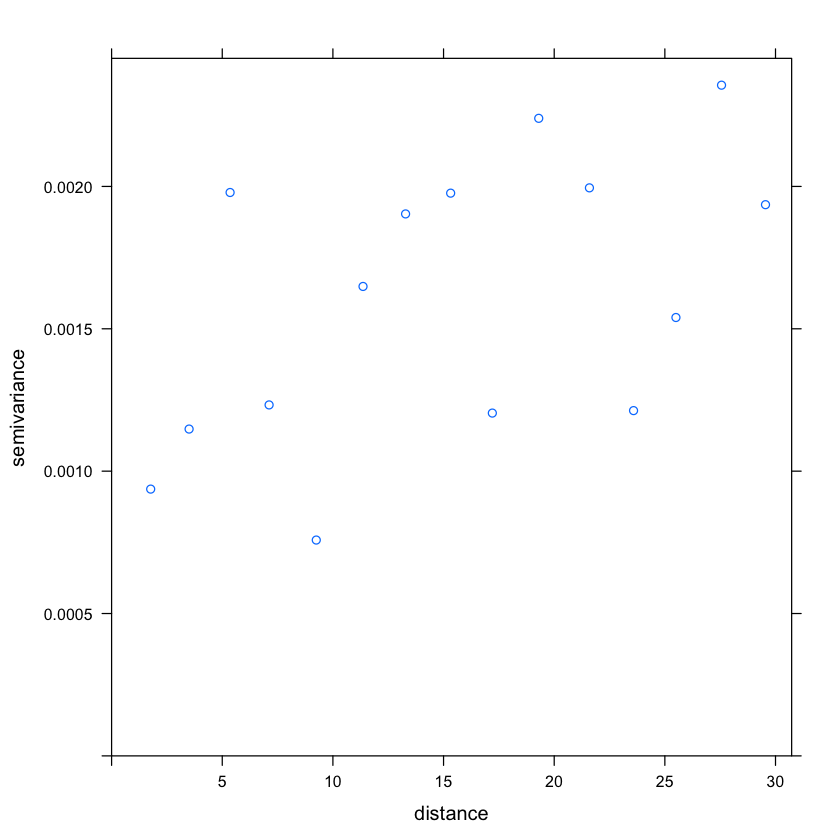

In [62]:
#Generate variogram
may.precip.vgm <- variogram(complete.sensor.precip$X2014_5_precip_mo ~ 1, complete.sensor.precip)
plot(may.precip.vgm)

This variogram follows the expected shape of a variogram much more closely than the temperature variogram did

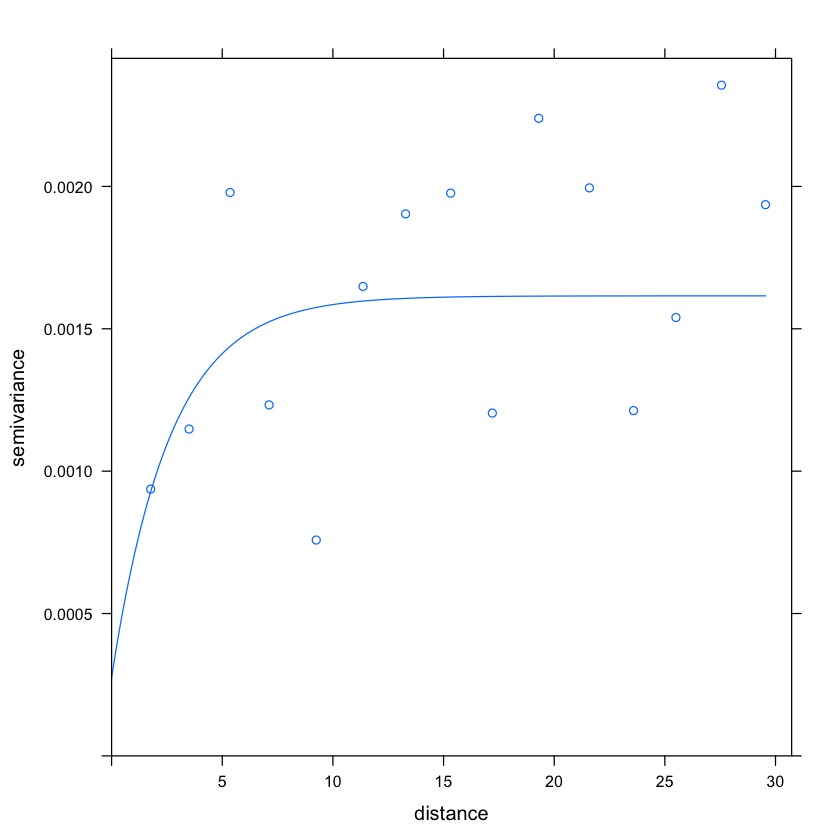

In [63]:
#Fitting a variogram model
precip.fit <- fit.variogram(may.precip.vgm, model=vgm("Exp"))
#plot
plot(may.precip.vgm, precip.fit)

In [64]:
#Generate prediction surface grid
pt2grid <- function(ptframe,n) {
  bb <- bbox(ptframe)  
  ptcrs <- proj4string(ptframe)  
  xrange <- abs(bb[1,1] - bb[1,2])  
  yrange <- abs(bb[2,1] - bb[2,2])  
  cs <- c(xrange/n,yrange/n)  
  cc <- bb[,1] + (cs/2)  
  dc <- c(n,n)  
  x1 <- GridTopology(cellcentre.offset=cc,cellsize=cs,cells.dim=dc)  
  x2 <- SpatialGrid(grid=x1,proj4string=CRS(ptcrs))
  return(x2)
}

#Create grid on Chicago
chi.grid <- pt2grid((chi.map),100)

## Krige and Visualize Interpolation

[using ordinary kriging]


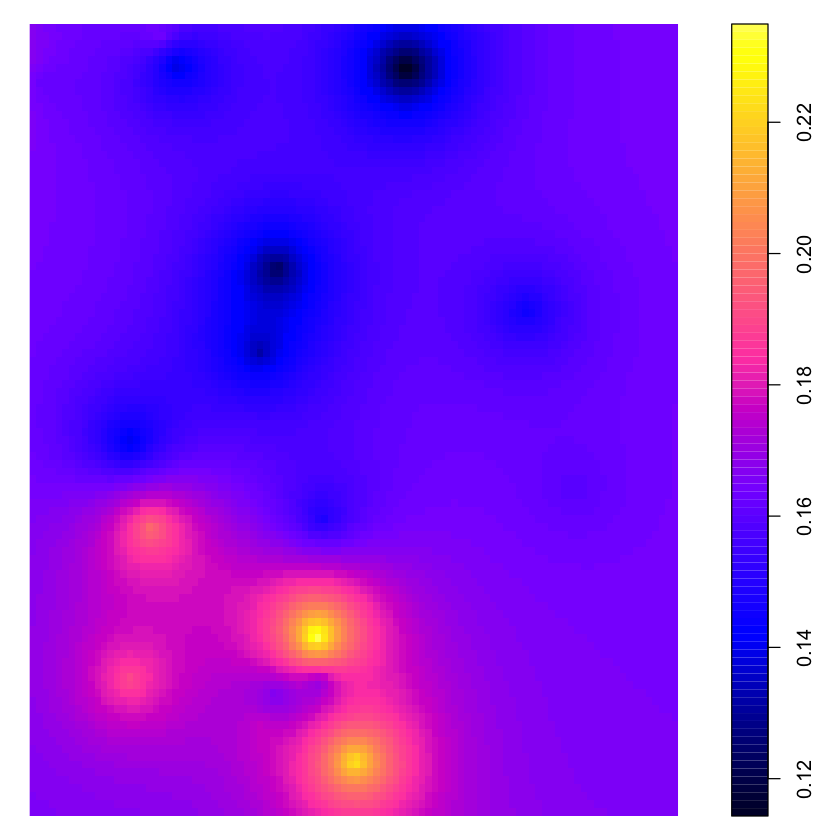

In [65]:
#Krige
precip.kriged <- krige(complete.sensor.precip$X2014_5_precip_mo ~ 1, complete.sensor.precip, Chi.Grid, model = precip.fit)
plot(precip.kriged)

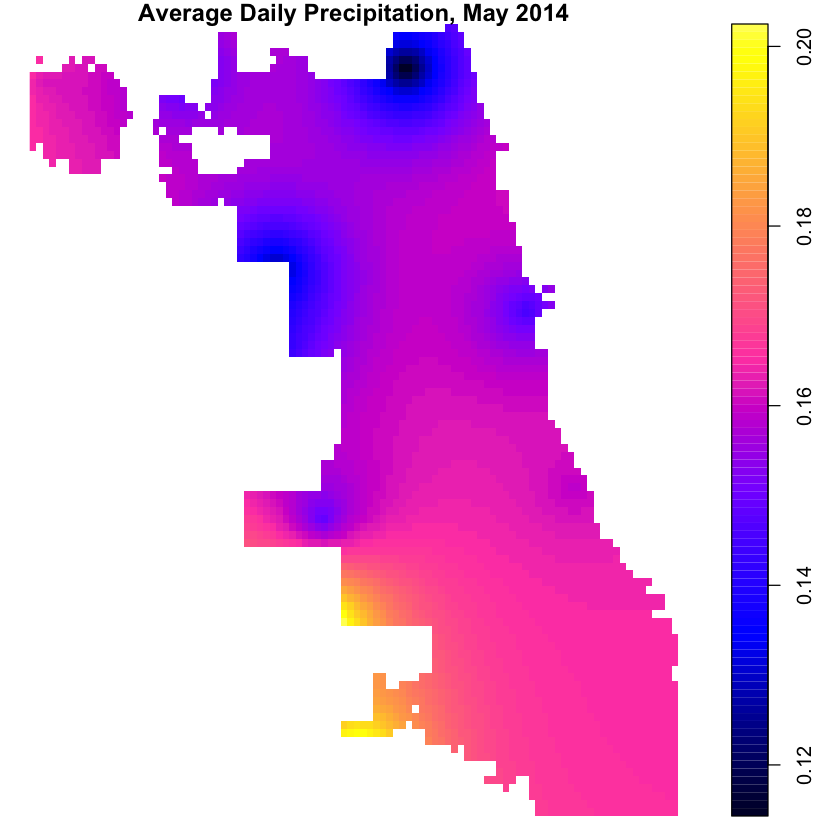

In [67]:
#Clip to city of Chicago
chi.precip.kriged <- precip.kriged[chi.map,]

#Visualize
plot(chi.precip.kriged)
title(main = "Average Daily Precipitation, May 2014", outer = FALSE)